In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

2024-04-12 07:18:52.750148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 07:18:52.750294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 07:18:52.924466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = "../input/ucf-crime-dataset/Train"
test_dir = "../input/ucf-crime-dataset/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
EPOCHS = 2
LR =  0.001

In [3]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


In [4]:
crime_types

['RoadAccidents',
 'Assault',
 'Vandalism',
 'Arrest',
 'Shooting',
 'NormalVideos',
 'Arson',
 'Explosion',
 'Shoplifting',
 'Robbery',
 'Stealing',
 'Burglary',
 'Abuse',
 'Fighting']

Crimes have been catogarized in 14 different types.

In [5]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir(os.path.join(train_dir,clss)))
    train+=num
    test+=len(os.listdir(os.path.join(test_dir,clss)))
    
    crimes[clss]=num

In [6]:
crimes

{'RoadAccidents': 23486,
 'Assault': 10360,
 'Vandalism': 13626,
 'Arrest': 26397,
 'Shooting': 7140,
 'NormalVideos': 947768,
 'Arson': 24421,
 'Explosion': 18753,
 'Shoplifting': 24835,
 'Robbery': 41493,
 'Stealing': 44802,
 'Burglary': 39504,
 'Abuse': 19076,
 'Fighting': 24684}

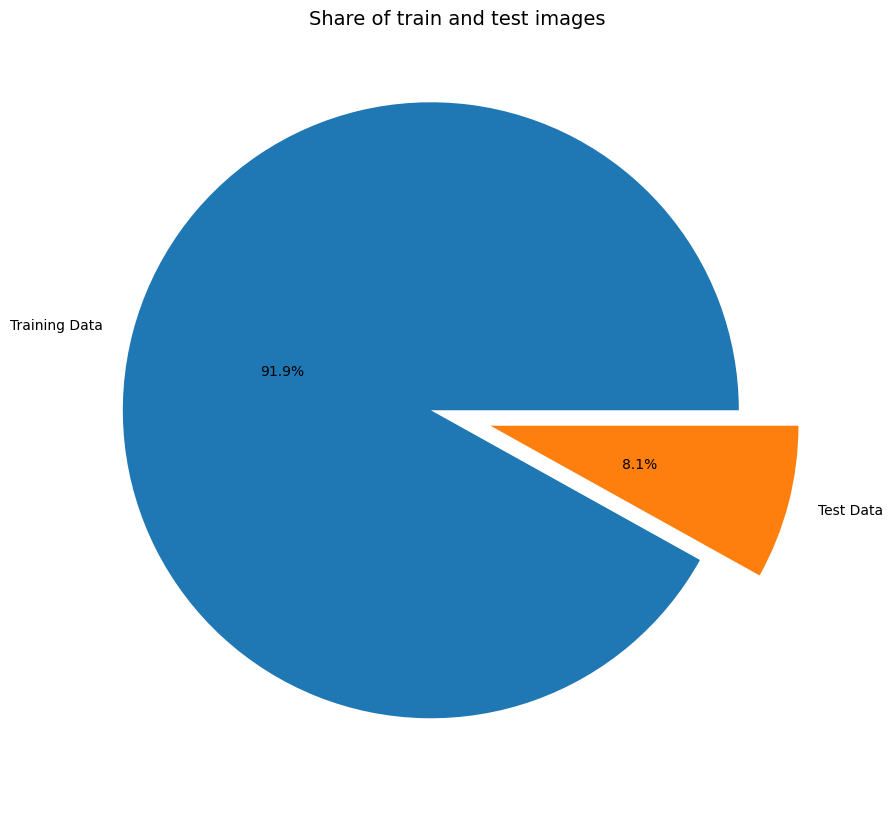

In [7]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

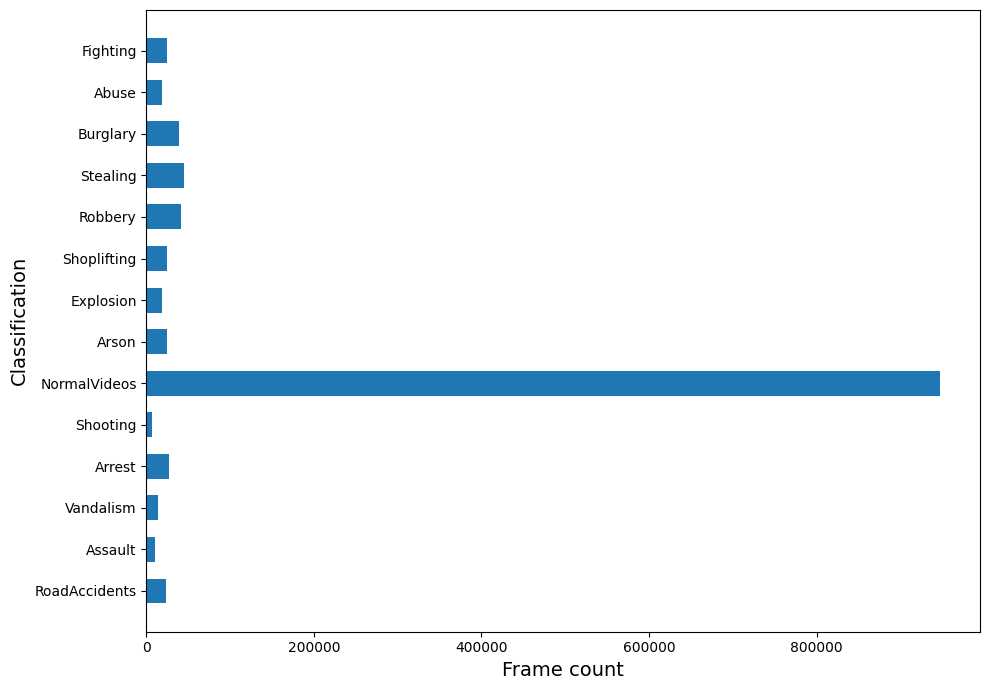

In [8]:
plt.figure(figsize=(10, 7))
plt.barh(list(crimes.keys()), list(crimes.values()), height=0.6, align="center")
plt.yticks(rotation=0)

plt.xlabel("Frame count", fontsize=14)
plt.ylabel("Classification", fontsize=14)
plt.tight_layout()
plt.show()


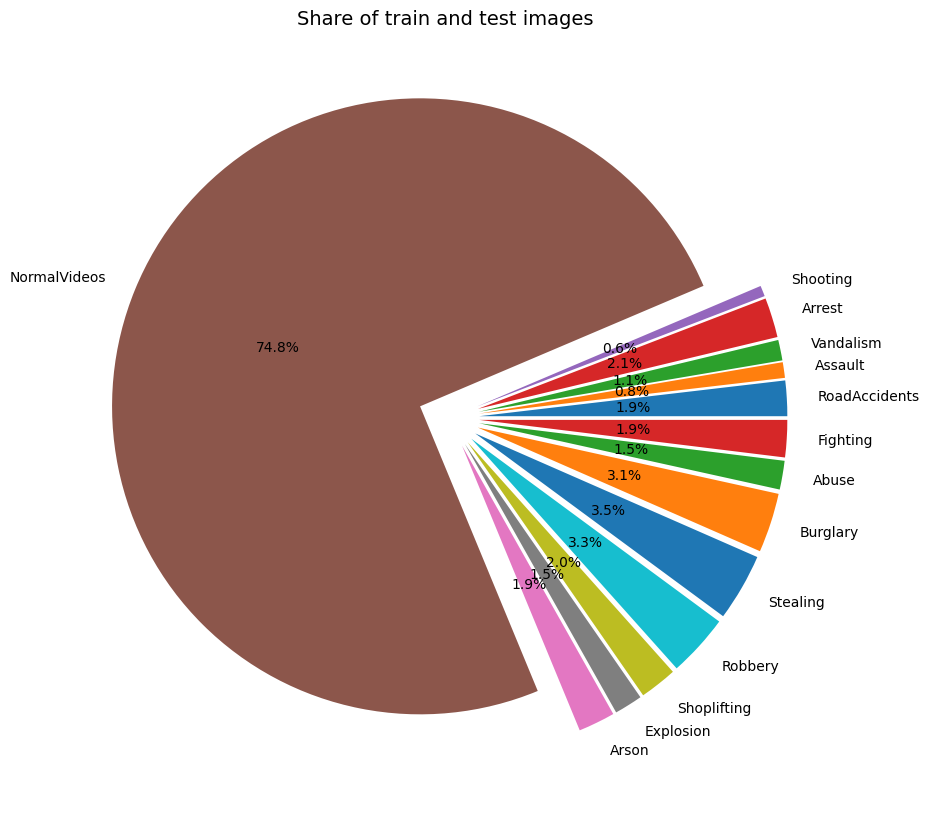

In [9]:
plt.figure(figsize=(15,10))
plt.pie(x=np.array(list(crimes.values())), autopct="%.1f%%", explode=[0.1]*n,labels=list(crimes.keys()), pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

In [10]:
IMG_WIDTH=64
IMG_HEIGHT=64

IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
seed=69

INPUT_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)

In [11]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set=image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=seed,
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.
Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.
Found 111308 files belonging to 14 classes.


In [18]:
from tensorflow.keras.applications import ResNet50

def create_resnet50_model():
    base_model = ResNet50(include_top=False, input_shape=INPUT_SHAPE, weights='/kaggle/input/resnet50-weights-tf-dim-ordering-tf-kernels-notop/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n, activation='softmax', name='classification'))
    
    model.summary()
    
    return model



In [19]:
model=create_resnet50_model()

model.compile(optimizer="adam", 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
history = model.fit(x = train_set,validation_data=val_set,epochs = EPOCHS)

Epoch 1/2
31659/31659 ━━━━━━━━━━━━━━━━━━━━ 10208s 322ms/step - auc: 0.9942 - loss: 0.2338 - val_auc: 0.9993 - val_loss: 0.0399
Epoch 2/2
31659/31659 ━━━━━━━━━━━━━━━━━━━━ 10278s 324ms/step - auc: 0.9987 - loss: 0.0668 - val_auc: 0.9995 - val_loss: 0.0288


In [21]:
y_true =  np.array([])

for x, y in test_set:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [22]:
y_pred=model.predict(test_set)

3479/3479 ━━━━━━━━━━━━━━━━━━━━ 866s 248ms/step


In [23]:
from sklearn.metrics import classification_report

# Convert y_pred to labels
y_pred_labels = np.argmax(y_pred, axis=-1)

# Generate classification report
report = classification_report(y_true, y_pred_labels)

print(report)


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       297
         1.0       0.02      0.03      0.02      3365
         2.0       0.17      0.22      0.19      2793
         3.0       0.00      0.00      0.00      2657
         4.0       0.16      0.05      0.08      7657
         5.0       0.21      0.02      0.03      6510
         6.0       0.00      0.01      0.00      1231
         7.0       0.68      0.85      0.75     64952
         8.0       0.20      0.17      0.18      2663
         9.0       0.00      0.00      0.00       835
        10.0       0.06      0.00      0.00      7630
        11.0       0.70      0.09      0.16      7623
        12.0       0.23      0.19      0.20      1984
        13.0       0.00      0.00      0.00      1111

    accuracy                           0.52    111308
   macro avg       0.17      0.12      0.12    111308
weighted avg       0.48      0.52      0.47    111308



In [24]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(crime_types):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.8198649806512276


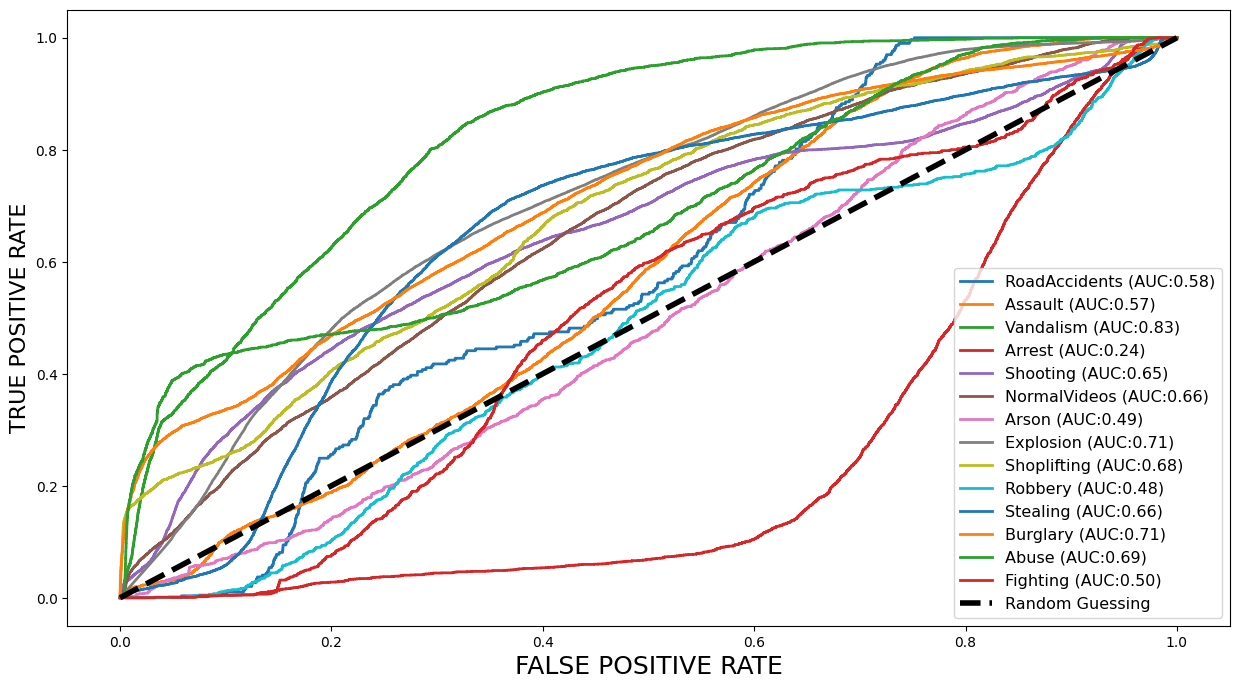

In [25]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))


print('ROC AUC score:', multiclass_roc_auc_score(y_true , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
# Save the model in HDF5 format
model.save('/kaggle/working/trainedModelResnet50.h5')